In [1]:
import pandas as pd

df = pd.read_pickle('../resources/data/preprocessed/womens_tournament_games.pkl')

df.head()

,winner,season,day_number,team0,team1,team0_loc,prev_matchups,common_opps_win_pct_diff,seed_diff,elo_diff,ordinal_elo_diff
0,0,2003,138,3130,3330,A,NaN,-0.166667,7,-158.060436,29
1,0,2003,138,3160,3140,H,NaN,0.100000,5,-144.780011,31
2,0,2003,138,3208,3150,H,NaN,0.050000,7,-119.080929,22
3,0,2003,138,3261,3402,N,1.0,-0.333333,15,-700.819496,166
4,0,2003,138,3278,3408,N,NaN,-0.500000,5,-176.969005,36


In [2]:
df.sort_values(['season'], inplace=True, ignore_index=True)

df

,winner,season,day_number,team0,team1,team0_loc,prev_matchups,common_opps_win_pct_diff,seed_diff,elo_diff,ordinal_elo_diff
0,0,2003,138,3130,3330,A,NaN,-0.166667,7,-158.060436,29
1,1,2003,147,3403,3181,N,NaN,0.000000,-1,213.861848,-7
2,1,2003,147,3437,3397,A,NaN,0.000000,-1,139.711227,-3
3,1,2003,148,3345,3163,N,NaN,0.000000,-1,239.091459,-10
4,1,2003,148,3261,3400,N,1.0,0.250000,1,-84.334299,1
...,...,...,...,...,...,...,...,...,...,...,...
2397,0,2022,140,3231,3343,H,NaN,NaN,8,34.026609,-6
2398,0,2022,140,3276,3437,H,NaN,-0.500000,8,-98.564829,19
2399,0,2022,140,3301,3243,H,1.0,0.000000,8,-370.519397,48
2400,0,2022,139,3377,3124,A,NaN,0.333333,-8,171.356569,-25


In [3]:
df = pd.get_dummies(df, columns=['team0_loc'])

df.drop(columns=['team0', 'team1', 'day_number', 'team0_loc_N'], inplace=True)

df.head()

,winner,season,prev_matchups,common_opps_win_pct_diff,seed_diff,elo_diff,ordinal_elo_diff,team0_loc_A,team0_loc_H
0,0,2003,NaN,-0.166667,7,-158.060436,29,1,0
1,1,2003,NaN,0.000000,-1,213.861848,-7,0,0
2,1,2003,NaN,0.000000,-1,139.711227,-3,1,0
3,1,2003,NaN,0.000000,-1,239.091459,-10,0,0
4,1,2003,1.0,0.250000,1,-84.334299,1,0,0


In [4]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, log_loss
# from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

predictions = []
feature_importances = []

for season in df['season'].unique():
    print(season)
    
    # s = MinMaxScaler()
    
    # split to in-sample and out-of-sample
    df_is = df.loc[~df['season'].isin([season]), :].reset_index(drop=True)
    df_oos = df.loc[df['season'].isin([season]), :].reset_index(drop=True)
    
    # train model
    eval_years = np.random.choice(df_is['season'].unique(), 5, replace=False)
    df_eval = df_is.loc[df_is['season'].isin(eval_years), :].reset_index(drop=True)
    df_train = df_is.loc[~df_is['season'].isin(eval_years), :].reset_index(drop=True)
    
    X_train = df_train.drop(columns=['winner', 'season'])
    # X_train = s.fit_transform(X_train)
    y_train = df_train['winner']
    
    X_eval = df_eval.drop(columns=['winner', 'season'])
    # X_eval = s.transform(X_eval)
    y_eval = df_eval['winner']    
    
    mod = xgb.XGBClassifier(objective='binary:logistic', seed=22, n_estimators=2000, 
                                    max_depth=1, eta=0.01)
    mod.fit(X_train, y_train, verbose=False, early_stopping_rounds=25, 
            eval_metric='logloss', eval_set=[(X_eval, y_eval)])
    
    
    # get out-of-sample predictions
    X_oos = df_oos.drop(columns=['winner', 'season'])
    # X_oos = s.transform(X_oos)
    y_oos = df_oos['winner']
    prediction = mod.predict_proba(X_oos)[:, 1]
    predictions.append(prediction)
    feature_importances.append(mod.feature_importances_)
    
    print(f"{season} Accuracy: {(y_oos == prediction.round()).mean():.2f}")
    print(f"{season} AUC: {roc_auc_score(y_oos, prediction):.2f}")
    print(f"{season} Logloss: {log_loss(y_oos, prediction):.2f}")
    
    print()
    
predictions = np.concatenate(predictions)
feature_importances = np.array(feature_importances).mean(axis=0)
    
'Done'

C:\Users\mhugh\anaconda3\envs\clean\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


2003
2003 Accuracy: 0.83
2003 AUC: 0.93
2003 Logloss: 0.38

2004
2004 Accuracy: 0.71
2004 AUC: 0.83
2004 Logloss: 0.50

2005
2005 Accuracy: 0.75
2005 AUC: 0.88
2005 Logloss: 0.43

2006
2006 Accuracy: 0.84
2006 AUC: 0.90
2006 Logloss: 0.41

2007
2007 Accuracy: 0.76
2007 AUC: 0.83
2007 Logloss: 0.50

2008
2008 Accuracy: 0.86
2008 AUC: 0.94
2008 Logloss: 0.36

2009
2009 Accuracy: 0.75
2009 AUC: 0.86
2009 Logloss: 0.44

2010
2010 Accuracy: 0.81
2010 AUC: 0.87
2010 Logloss: 0.43

2011
2011 Accuracy: 0.70
2011 AUC: 0.85
2011 Logloss: 0.43

2012
2012 Accuracy: 0.87
2012 AUC: 0.90
2012 Logloss: 0.45

2013
2013 Accuracy: 0.73
2013 AUC: 0.83
2013 Logloss: 0.51

2014
2014 Accuracy: 0.77
2014 AUC: 0.87
2014 Logloss: 0.41

2015
2015 Accuracy: 0.83
2015 AUC: 0.89
2015 Logloss: 0.43

2016
2016 Accuracy: 0.70
2016 AUC: 0.84
2016 Logloss: 0.48

2017
2017 Accuracy: 0.81
2017 AUC: 0.89
2017 Logloss: 0.42

2018
2018 Accuracy: 0.72
2018 AUC: 0.87
2018 Logloss: 0.43

2019
2019 Accuracy: 0.83
2019 AUC: 0.91


'Done'

In [5]:
(df['winner'] == predictions.round()).mean()

0.7793505412156536

In [6]:
roc_auc_score(df['winner'], predictions)

0.8687324121378175

In [7]:
log_loss(df['winner'], predictions)

0.4407713500792347

In [8]:
features = (
    pd.DataFrame({'feature': X_oos.columns, 
                  'importance': feature_importances}).sort_values(['importance'], 
                                                                  ascending=False, 
                                                                  ignore_index=True)
)

features

,feature,importance
0,seed_diff,0.537158
1,elo_diff,0.315602
2,team0_loc_H,0.043690
3,team0_loc_A,0.043656
4,ordinal_elo_diff,0.029951
5,common_opps_win_pct_diff,0.029333
6,prev_matchups,0.000610


In [9]:
df.drop(columns=features.loc[features['importance'] < 0.01, 'feature'], inplace=True)

df

,winner,season,common_opps_win_pct_diff,seed_diff,elo_diff,ordinal_elo_diff,team0_loc_A,team0_loc_H
0,0,2003,-0.166667,7,-158.060436,29,1,0
1,1,2003,0.000000,-1,213.861848,-7,0,0
2,1,2003,0.000000,-1,139.711227,-3,1,0
3,1,2003,0.000000,-1,239.091459,-10,0,0
4,1,2003,0.250000,1,-84.334299,1,0,0
...,...,...,...,...,...,...,...,...
2397,0,2022,NaN,8,34.026609,-6,0,1
2398,0,2022,-0.500000,8,-98.564829,19,0,1
2399,0,2022,0.000000,8,-370.519397,48,0,1
2400,0,2022,0.333333,-8,171.356569,-25,1,0


In [10]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, log_loss
# from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

predictions = []
feature_importances = []

for season in df['season'].unique():
    print(season)
    
    # s = MinMaxScaler()
    
    # split to in-sample and out-of-sample
    df_is = df.loc[~df['season'].isin([season]), :].reset_index(drop=True)
    df_oos = df.loc[df['season'].isin([season]), :].reset_index(drop=True)
    
    # train model
    eval_years = np.random.choice(df_is['season'].unique(), 5, replace=False)
    df_eval = df_is.loc[df_is['season'].isin(eval_years), :].reset_index(drop=True)
    df_train = df_is.loc[~df_is['season'].isin(eval_years), :].reset_index(drop=True)
    
    X_train = df_train.drop(columns=['winner', 'season'])
    # X_train = s.fit_transform(X_train)
    y_train = df_train['winner']
    
    X_eval = df_eval.drop(columns=['winner', 'season'])
    # X_eval = s.transform(X_eval)
    y_eval = df_eval['winner']    
    
    mod = xgb.XGBClassifier(objective='binary:logistic', seed=22, n_estimators=2000, 
                                    max_depth=1, eta=0.01)
    mod.fit(X_train, y_train, verbose=False, early_stopping_rounds=25, 
            eval_metric='logloss', eval_set=[(X_eval, y_eval)])
    
    
    # get out-of-sample predictions
    X_oos = df_oos.drop(columns=['winner', 'season'])
    # X_oos = s.transform(X_oos)
    y_oos = df_oos['winner']
    prediction = mod.predict_proba(X_oos)[:, 1]
    predictions.append(prediction)
    feature_importances.append(mod.feature_importances_)
    
    print(f"{season} Accuracy: {(y_oos == prediction.round()).mean():.2f}")
    print(f"{season} AUC: {roc_auc_score(y_oos, prediction):.2f}")
    print(f"{season} Logloss: {log_loss(y_oos, prediction):.2f}")
    
    print()
    
predictions = np.concatenate(predictions)
feature_importances = np.array(feature_importances).mean(axis=0)
    
'Done'

2003
2003 Accuracy: 0.83
2003 AUC: 0.93
2003 Logloss: 0.38

2004
2004 Accuracy: 0.73
2004 AUC: 0.82
2004 Logloss: 0.51

2005
2005 Accuracy: 0.75
2005 AUC: 0.88
2005 Logloss: 0.44

2006
2006 Accuracy: 0.83
2006 AUC: 0.89
2006 Logloss: 0.42

2007
2007 Accuracy: 0.76
2007 AUC: 0.83
2007 Logloss: 0.51

2008
2008 Accuracy: 0.84
2008 AUC: 0.95
2008 Logloss: 0.33

2009
2009 Accuracy: 0.75
2009 AUC: 0.87
2009 Logloss: 0.43

2010
2010 Accuracy: 0.81
2010 AUC: 0.87
2010 Logloss: 0.43

2011
2011 Accuracy: 0.70
2011 AUC: 0.86
2011 Logloss: 0.45

2012
2012 Accuracy: 0.88
2012 AUC: 0.91
2012 Logloss: 0.42

2013
2013 Accuracy: 0.76
2013 AUC: 0.85
2013 Logloss: 0.48

2014
2014 Accuracy: 0.79
2014 AUC: 0.87
2014 Logloss: 0.41

2015
2015 Accuracy: 0.83
2015 AUC: 0.89
2015 Logloss: 0.42

2016
2016 Accuracy: 0.70
2016 AUC: 0.84
2016 Logloss: 0.48

2017
2017 Accuracy: 0.81
2017 AUC: 0.88
2017 Logloss: 0.44

2018
2018 Accuracy: 0.75
2018 AUC: 0.87
2018 Logloss: 0.42

2019
2019 Accuracy: 0.84
2019 AUC: 0.91


'Done'

In [11]:
(df['winner'] == predictions.round()).mean()

0.7822647793505412

In [12]:
roc_auc_score(df['winner'], predictions)

0.8715305244519382

In [13]:
log_loss(df['winner'], predictions)

0.4360015524049068

In [14]:
features = (
    pd.DataFrame({'feature': X_oos.columns, 
                  'importance': feature_importances}).sort_values(['importance'], 
                                                                  ascending=False, 
                                                                  ignore_index=True)
)

features

,feature,importance
0,seed_diff,0.546733
1,elo_diff,0.314791
2,team0_loc_H,0.040152
3,team0_loc_A,0.039991
4,common_opps_win_pct_diff,0.033384
5,ordinal_elo_diff,0.024949


<AxesSubplot:ylabel='Count'>

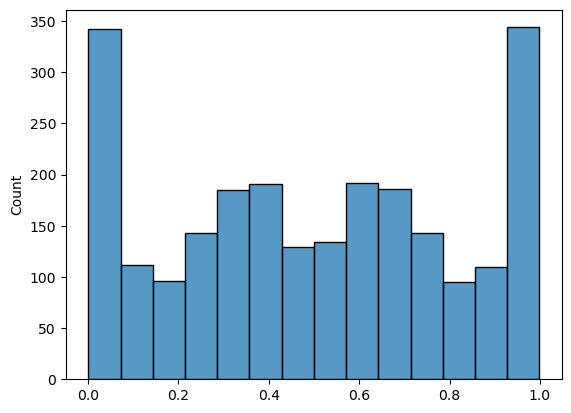

In [15]:
import seaborn as sns

sns.histplot(x=predictions)

In [16]:
df_acc = pd.read_pickle('../resources/data/preprocessed/womens_tournament_games.pkl')[['winner', 'season', 
                                                                                       'team0', 'team1', 
                                                                                       'seed_diff']]

df_acc.sort_values(['season'], inplace=True, ignore_index=True)

df_acc['prediction'] = predictions

df_acc

,winner,season,team0,team1,seed_diff,prediction
0,0,2003,3130,3330,7,0.292627
1,1,2003,3403,3181,-1,0.700910
2,1,2003,3437,3397,-1,0.656748
3,1,2003,3345,3163,-1,0.700910
4,1,2003,3261,3400,1,0.388151
...,...,...,...,...,...,...
2397,0,2022,3231,3343,8,0.323033
2398,0,2022,3276,3437,8,0.276393
2399,0,2022,3301,3243,8,0.095692
2400,0,2022,3377,3124,-8,0.756760


In [17]:
df_acc['correct'] = df_acc['winner'] == df_acc['prediction'].round()

df_acc

,winner,season,team0,team1,seed_diff,prediction,correct
0,0,2003,3130,3330,7,0.292627,True
1,1,2003,3403,3181,-1,0.700910,True
2,1,2003,3437,3397,-1,0.656748,True
3,1,2003,3345,3163,-1,0.700910,True
4,1,2003,3261,3400,1,0.388151,False
...,...,...,...,...,...,...,...
2397,0,2022,3231,3343,8,0.323033,True
2398,0,2022,3276,3437,8,0.276393,True
2399,0,2022,3301,3243,8,0.095692,True
2400,0,2022,3377,3124,-8,0.756760,False


In [18]:
df_acc_by_seed = df_acc.groupby(['seed_diff'])['correct'].mean().round(2)

df_acc_by_seed

seed_diff
-15    1.00
-13    1.00
-12    1.00
-11    1.00
-10    1.00
-9     0.94
-8     0.81
-7     0.85
-6     0.67
-5     0.73
-4     0.83
-3     0.66
-2     0.74
-1     0.59
 0     0.66
 1     0.59
 2     0.74
 3     0.66
 4     0.83
 5     0.73
 6     0.67
 7     0.85
 8     0.81
 9     0.94
 10    1.00
 11    1.00
 12    1.00
 13    1.00
 15    1.00
Name: correct, dtype: float64

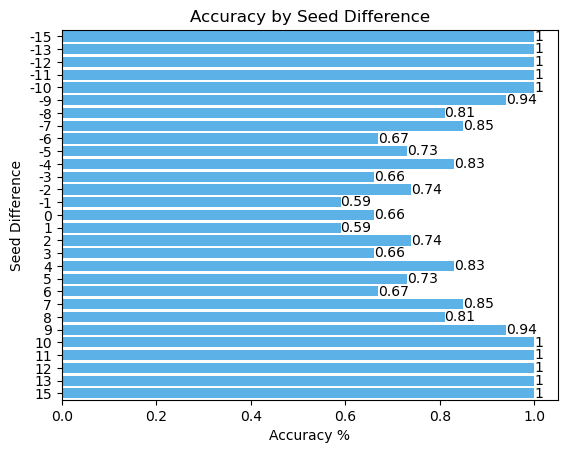

In [19]:
import matplotlib.pyplot as plt

ax = sns.barplot(x=df_acc_by_seed, y=df_acc_by_seed.index, 
                 orient='h', color='#45B6FE')

ax.bar_label(ax.containers[0])

plt.xlabel('Accuracy %')
plt.ylabel('Seed Difference')
plt.title('Accuracy by Seed Difference')

plt.show()

In [22]:
eval_years = np.random.choice(df['season'].unique(), 5, replace=False)
print(eval_years)
df_eval = df.loc[df['season'].isin(eval_years), :].reset_index(drop=True)
df_train = df.loc[~df['season'].isin(eval_years), :].reset_index(drop=True)

X_train = df_train.drop(columns=['winner', 'season'])
columns = X_train.columns
# X_train = s.fit_transform(X_train)
y_train = df_train['winner']

X_eval = df_eval.drop(columns=['winner', 'season'])
# X_eval = s.transform(X_eval)
y_eval = df_eval['winner']

best_mod = xgb.XGBClassifier(objective='binary:logistic', seed=22, n_estimators=2500, 
                             max_depth=1, eta=0.01)

best_mod.fit(X_train, y_train, verbose=True, early_stopping_rounds=50, 
             eval_metric='logloss', eval_set=[(X_eval, y_eval)])

[2003 2009 2006 2010 2018]
[0]	validation_0-logloss:0.69001
[1]	validation_0-logloss:0.68692
[2]	validation_0-logloss:0.68390
[3]	validation_0-logloss:0.68093
[4]	validation_0-logloss:0.67802
[5]	validation_0-logloss:0.67516
[6]	validation_0-logloss:0.67236
[7]	validation_0-logloss:0.66960
[8]	validation_0-logloss:0.66690
[9]	validation_0-logloss:0.66425
[10]	validation_0-logloss:0.66164
[11]	validation_0-logloss:0.65909
[12]	validation_0-logloss:0.65658
[13]	validation_0-logloss:0.65412
[14]	validation_0-logloss:0.65181
[15]	validation_0-logloss:0.64953
[16]	validation_0-logloss:0.64729
[17]	validation_0-logloss:0.64508
[18]	validation_0-logloss:0.64291
[19]	validation_0-logloss:0.64077
[20]	validation_0-logloss:0.63867
[21]	validation_0-logloss:0.63660
[22]	validation_0-logloss:0.63445
[23]	validation_0-logloss:0.63245
[24]	validation_0-logloss:0.63047
[25]	validation_0-logloss:0.62852
[26]	validation_0-logloss:0.62660
[27]	validation_0-logloss:0.62472
[28]	validation_0-logloss:0.622

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.01, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.00999999978,
              max_delta_step=0, max_depth=1, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=2500, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=22,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=22,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [23]:
features

,feature,importance
0,seed_diff,0.546733
1,elo_diff,0.314791
2,team0_loc_H,0.040152
3,team0_loc_A,0.039991
4,common_opps_win_pct_diff,0.033384
5,ordinal_elo_diff,0.024949


In [24]:
pd.DataFrame({'feature': columns, 'importance': best_mod.feature_importances_}).sort_values(['importance'], 
                                                                                            ascending=False, 
                                                                                            ignore_index=True)

,feature,importance
0,seed_diff,0.557630
1,elo_diff,0.326667
2,ordinal_elo_diff,0.030207
3,common_opps_win_pct_diff,0.029502
4,team0_loc_A,0.028046
5,team0_loc_H,0.027948


In [25]:
import pickle

with open('../resources/models/womens_XGBoost.pkl', 'wb') as handle:
    pickle.dump(best_mod, handle, protocol=pickle.HIGHEST_PROTOCOL)

'Done'

'Done'

In [26]:
X_train.columns

Index(['common_opps_win_pct_diff', 'seed_diff', 'elo_diff', 'ordinal_elo_diff',
       'team0_loc_A', 'team0_loc_H'],
      dtype='object')